In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


In [3]:
# Load Titanic datasets (upload train.csv and test.csv to Colab first)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Display information about both datasets
train.info()
test.info()

# Preview first few rows
train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Drop irrelevant columns
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Check missing values
print("Missing values in training data:\n", train.isnull().sum())
print("\nMissing values in test data:\n", test.isnull().sum())

# Fill missing Embarked and Fare values
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].dropna().mode()[0])
test['Fare'] = test['Fare'].fillna(test['Fare'].dropna().mean())


Missing values in training data:
 Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Missing values in test data:
 Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64


In [5]:
# Guess missing Age values based on Sex and Pclass
guess_ages = np.zeros((2, 3))

for dataset in [train, test]:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == ('male' if i == 1 else 'female')) &
                               (dataset['Pclass'] == j + 1)]['Age'].dropna()
            age_guess = guess_df.median()
            guess_ages[i, j] = age_guess

    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[(dataset.Age.isnull()) &
                        (dataset.Sex == ('male' if i == 1 else 'female')) &
                        (dataset.Pclass == j + 1), 'Age'] = guess_ages[i, j]

    dataset['Age'] = dataset['Age'].astype(int)


In [6]:
# Convert categorical variables into numeric
for dataset in [train, test]:
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(int)
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

# Verify the processed dataset
train.head()


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22,1,0,7.2500,0
1,1,1,1,38,1,0,71.2833,1
2,1,3,1,26,0,0,7.9250,0
3,1,1,1,35,1,0,53.1000,0
4,0,3,0,35,0,0,8.0500,0


In [7]:
# Prepare features and target variable
X_train = pd.get_dummies(train.drop(['Survived'], axis=1))
Y_train = train['Survived']
X_test = pd.get_dummies(test)


In [8]:
# Define a helper function to display model scores
def print_scores(model, X_train, Y_train, predictions, cv_splits=10):
    print(f"The mean accuracy score of the train data is: {model.score(X_train, Y_train):.5f}")
    cv_scores = cross_val_score(model, X_train, Y_train, cv=cv_splits)
    print(f"The individual cross-validation scores are: {cv_scores}")
    print(f"The minimum cross-validation score is: {np.min(cv_scores):.5f}")
    print(f"The maximum cross-validation score is: {np.max(cv_scores):.5f}")
    print(f"The mean cross-validation score is: {np.mean(cv_scores):.5f} ± {np.std(cv_scores) * 2:.2f}")


In [9]:
# Create and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=80, max_depth=8, max_features=8, random_state=7)
model.fit(X_train, Y_train)

# Make predictions
predictions = model.predict(X_test)

# Print model performance scores
print_scores(model, X_train, Y_train, predictions)


The mean accuracy score of the train data is: 0.92817
The individual cross-validation scores are: [0.76666667 0.80898876 0.76404494 0.88764045 0.92134831 0.85393258
 0.80898876 0.78651685 0.86516854 0.84269663]
The minimum cross-validation score is: 0.76404
The maximum cross-validation score is: 0.92135
The mean cross-validation score is: 0.83060 ± 0.10


In [10]:
# Save predictions to CSV file (optional)
submission = pd.DataFrame({
    "PassengerId": pd.read_csv('test.csv')['PassengerId'],  # read original to get IDs
    "Survived": predictions
})
submission.to_csv('submission.csv', index=False)
print("✅ Submission file 'submission.csv' created successfully!")


✅ Submission file 'submission.csv' created successfully!


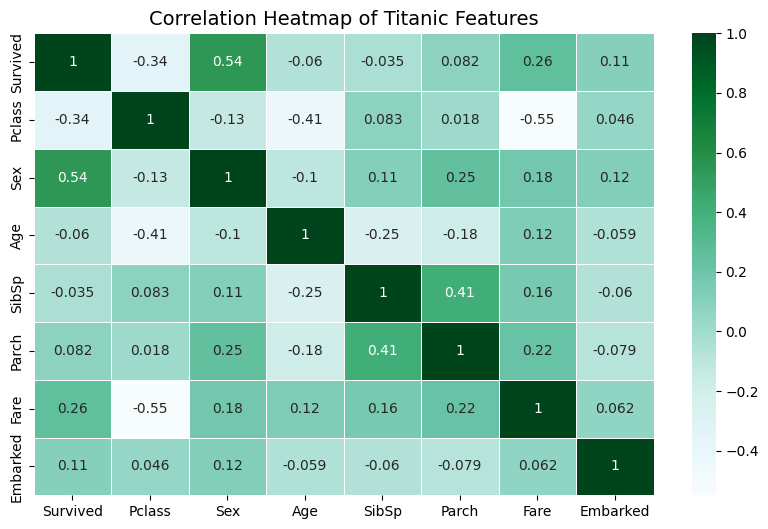

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot heatmap of correlations between numerical features
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr(), annot=True, cmap='BuGn', linewidths=0.5)
plt.title("Correlation Heatmap of Titanic Features", fontsize=14)
plt.show()


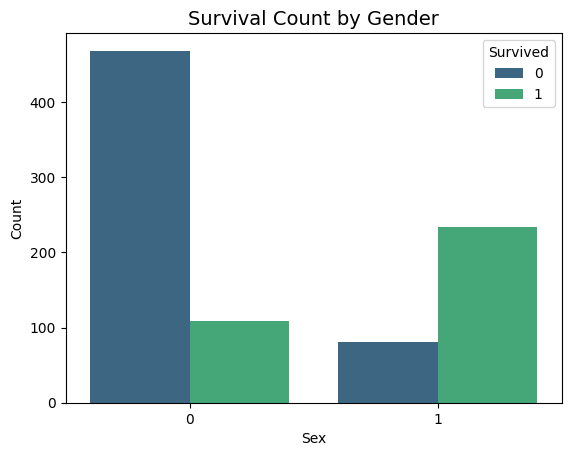

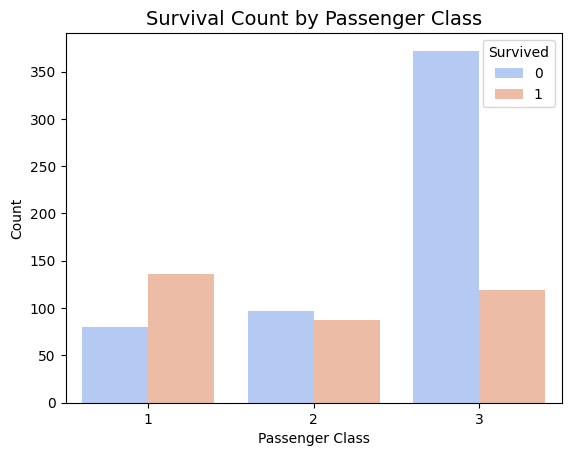

In [12]:
# Plot survival count by gender
sns.countplot(x='Sex', hue='Survived', data=train, palette='viridis')
plt.title('Survival Count by Gender', fontsize=14)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Plot survival count by passenger class
sns.countplot(x='Pclass', hue='Survived', data=train, palette='coolwarm')
plt.title('Survival Count by Passenger Class', fontsize=14)
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.show()


/tmp/ipython-input-3141069669.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette='crest')


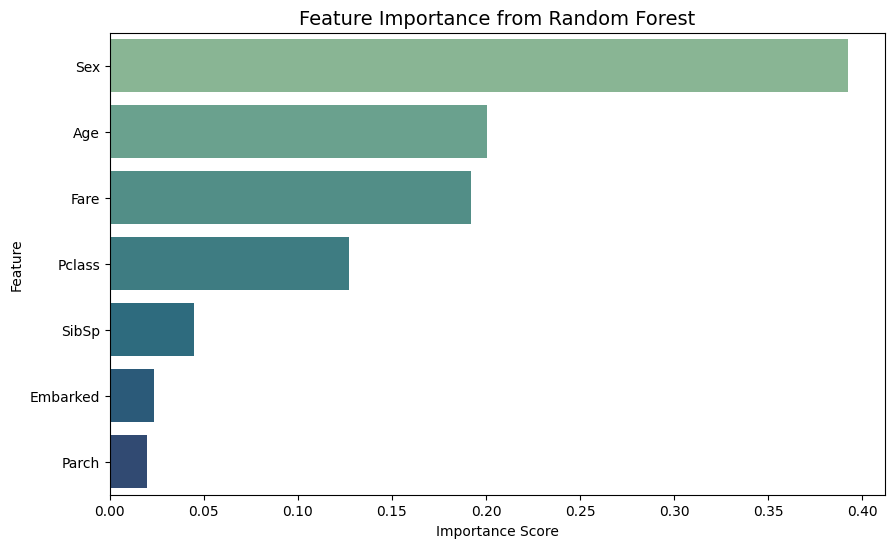

In [13]:
# Show feature importance from the trained Random Forest model
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index, palette='crest')
plt.title("Feature Importance from Random Forest", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


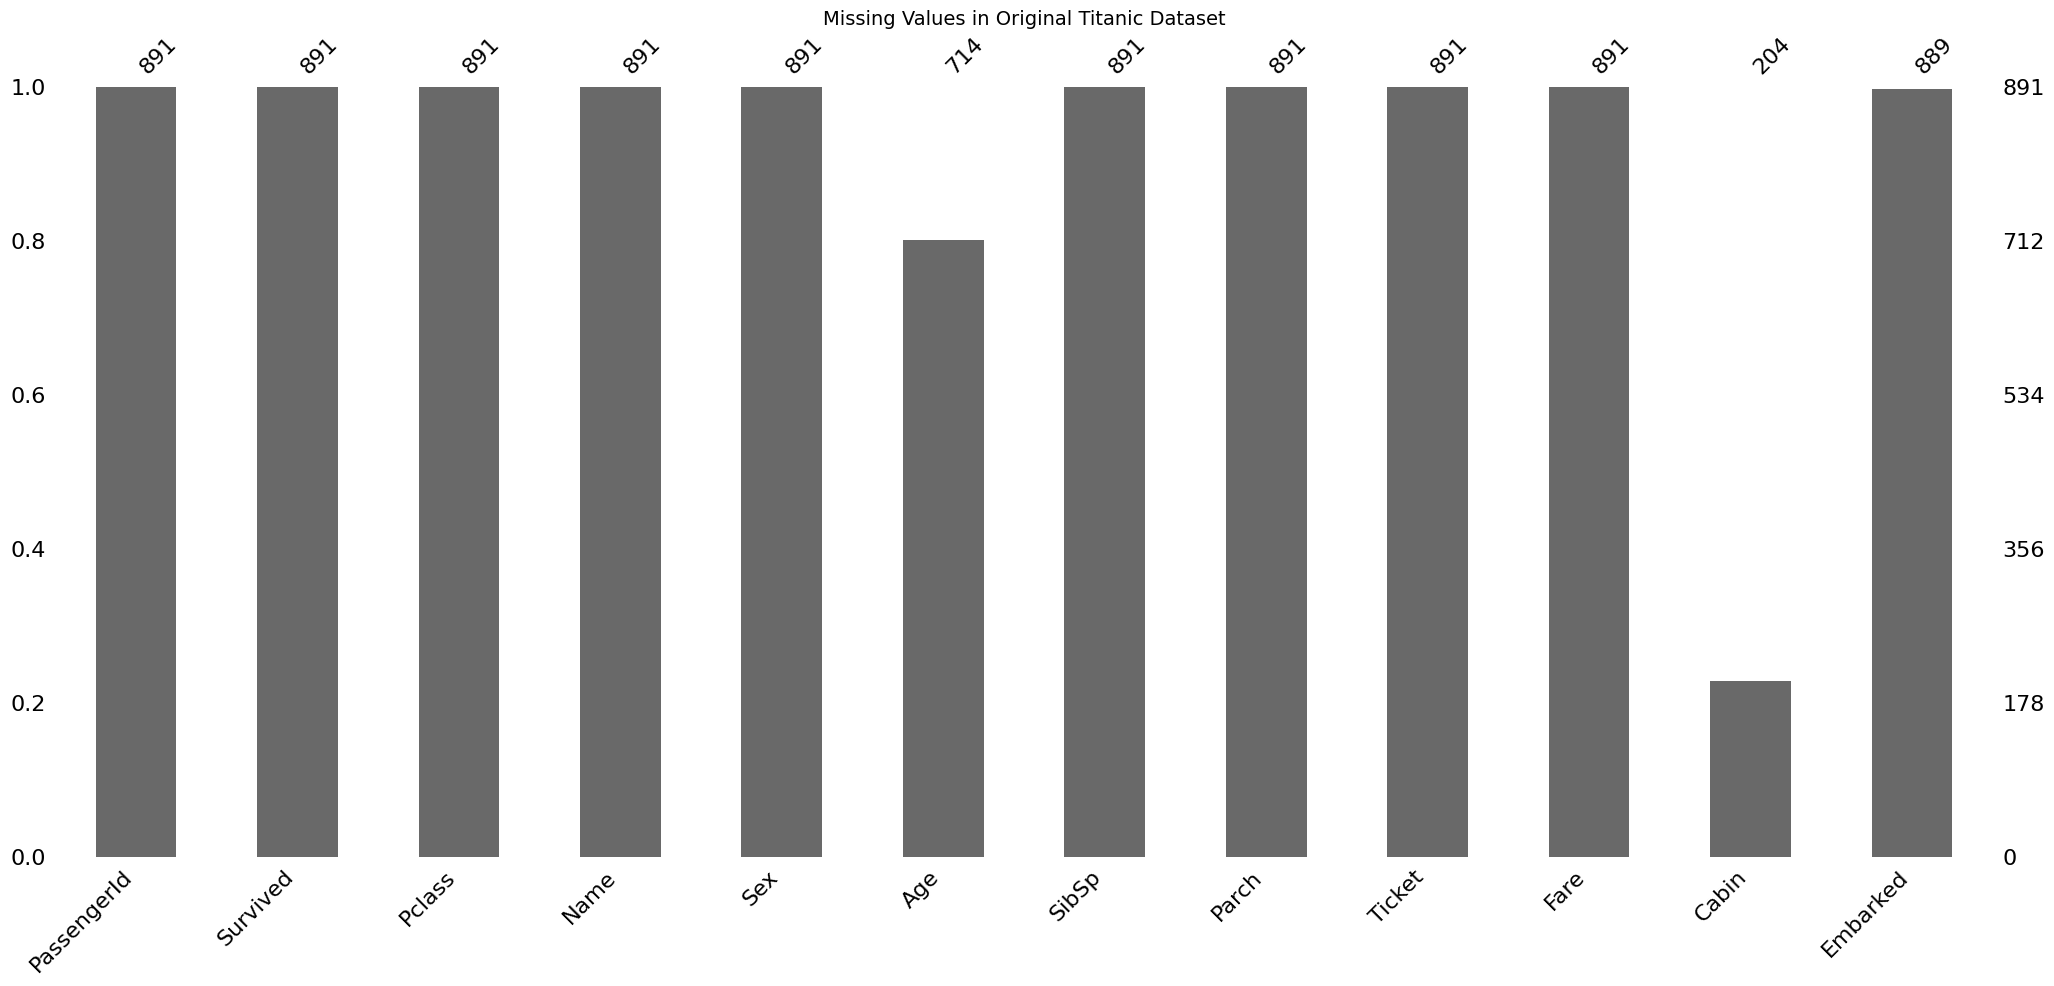

In [14]:
# Visualize missing values before preprocessing (if you want to show before cleaning)
import missingno as msno

# Reload original data to show missing values
raw_train = pd.read_csv('train.csv')
plt.figure(figsize=(8, 5))
msno.bar(raw_train)
plt.title("Missing Values in Original Titanic Dataset", fontsize=14)
plt.show()
